In [134]:
import numpy as np
from scipy.linalg import eigh

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sampling import mixed_gaussian_dataset_generator
from projecting import capped_simplex_projection, kullbeck_leibler_projection
from utils import diameter

# Dataset

Dataset generated following a mixed Gaussian model. Data sampled within given lower and upper bounds.

Gaussian mix is sampled at random.

In [135]:
lower_bnds = [0,0,0]
upper_bnds = [100,100,100]

N = 250 # number of data points

num_centers = 1 # number of centers in gaussian mix

In [136]:
x, centers, weights, covs = mixed_gaussian_dataset_generator(lower_bnds, upper_bnds, num_centers, N)

# Covariance

Let $\Delta_n = \{ w \in \mathbb{R}^n \,\vert\, w_i \geq 0, \sum_i w_i =1 \}$. Consider $\{x_i\}_{i=1}^n \subseteq \mathbb{R}^d$ and a weight vector $w \in \Delta_n$.

The empirical weighted covariance operator relative to center $\nu \in \mathbb{R}^d$ is given by,

$$M(x,\nu,w) = \sum_{i=1}^N w_i (x_i-\nu)(x_i-\nu)^T = \sum_{i=1}^N w_i \lvert x_i-\nu \rangle \langle x_i-\nu\rvert$$

In [137]:
def M(x,nu,w):
    
    return (x-nu).T@(np.diag(w)@(x-nu))

In [138]:
dim = x.shape[-1]
nu_mean = np.mean(x,axis=0)

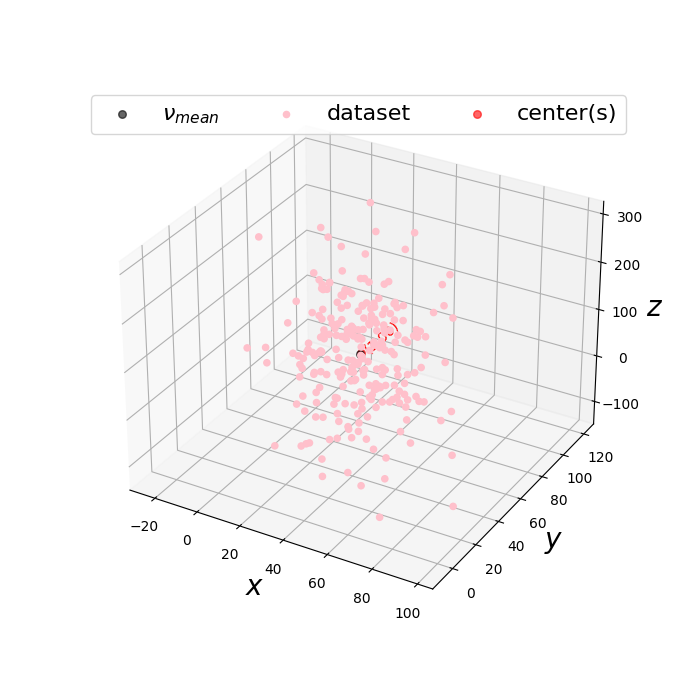

In [139]:
%matplotlib ipympl


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=Axes3D.name)

ax.scatter(nu_mean[None,:][:,0],nu_mean[None,:][:,1],nu_mean[None,:][:,2],s=30,c='black',alpha=0.6,label=r'$\nu_{mean}$')
ax.scatter(x[:,0],x[:,1],x[:,2],s=20,c='pink',alpha=1,label='dataset')

for i in range(num_centers):
    if i==0:
        ax.scatter(centers[i,0],centers[i,1],centers[i,2],s=30,c='red',label='center(s)',alpha=0.6,zorder=10)
    else:
        ax.scatter(centers[i,0],centers[i,1],centers[i,2],s=30,c='red',alpha=0.6,zorder=10)
    label = '({:.2f})'.format(weights[i])
    ax.text(centers[i,0],centers[i,1],centers[i,2],label,'y',c='red')


ax.legend(loc='upper center',fontsize=16, ncol=4)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$y$', fontsize=20)
ax.set_zlabel('$z$', fontsize=20)

plt.show()

# Sample Re-weighting w/ Online Gradient Descent

$\rho$ - squared diameter of dataset.

The cost function is $L$-Lipschitz with $L = \sqrt{n}\rho$.

$R = \sqrt{2}$.

Learning rate of algorithm is $\eta_t = R/L\sqrt{t}$.

In [140]:
T = 50
epsilon = 0.5

R = np.sqrt(2)
dim = x.shape[-1]
rho = diameter(x)**2
L = np.sqrt(N)*rho

In [155]:
w = np.ones(N)[None,:]/N
nu = np.array([[] for _ in range(dim)]).T
specMs = []

for t in range(1,T+1):

    w_t = w[-1]
    nu_t = w_t@x
    M_t = M(x,nu_t,w_t)
    eval_t, v_t = eigh(M_t,eigvals=[dim-1,dim-1])
    tau_t = ((x - nu_t)@v_t)**2
    eta_t = R/(L*np.sqrt(t))
    w_t = w_t - eta_t*tau_t.T
    w_t = w_t/w_t.sum()
    w_t = capped_simplex_projection(w_t,t=1/((1-epsilon)*N))

    w = np.vstack([w,w_t])
    nu = np.vstack([nu,nu_t[None,:]])
    specMs.append(eval_t)
    
w_t = w[-1]
nu_t = w_t@x
M_t = M(x,nu_t,w_t)
eval_t, _ = eigh(M_t,eigvals=[dim-1,dim-1])
nu = np.vstack([nu,nu_t[None,:]])
specMs.append(eval_t)

In [156]:
w_best = w[np.argmin(np.vstack(specMs))]

print('Test optimal weights:\nWeights add up to: {:.1f}'.format(np.sum(w_best)))
print('In set W_{{n,\\epsilon}}: {}'.format(np.sum(w_best<=1/((1-epsilon)*N))==N))

Test optimal weights:
Weights add up to: 1.0
In set W_{n,\epsilon}: True


In [157]:
nu_best = nu[np.argmin(np.vstack(specMs))]

In [158]:
nu_best

array([35.52966758, 54.22830097, 75.57614588])

In [159]:
nu_mean

array([35.50813693, 54.58997249, 72.75060479])

In [160]:
centers

array([[35.52210284, 55.86643506, 73.32648299]])

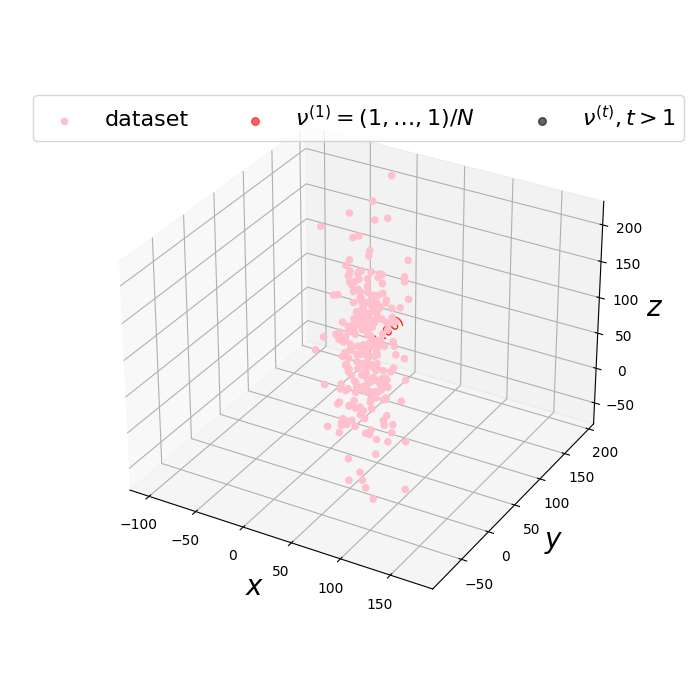

In [162]:
%matplotlib ipympl

zoom = 1.5

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')

ax.scatter(x[:,0],x[:,1],x[:,2],s=20,c='pink',alpha=1,label='dataset',zorder=0)

for i in range(T+1):
    if i==0:
        ax.scatter(nu[i,0],nu[i,1],nu[i,2],s=30,c='red',alpha=0.6,label=r'$\nu^{(1)}=(1,\ldots,1)/N$',zorder=5)
    elif i==T:
        ax.scatter(nu[i,0],nu[i,1],nu[i,2],s=30,c='black',alpha=0.6,label=r'$\nu^{(t)},t>1$',zorder=5)
    else:
        ax.scatter(nu[i,0],nu[i,1],nu[i,2],s=30,c='black',alpha=0.6,zorder=10)

for i in range(num_centers):
    ax.scatter(centers[i,0],centers[i,1],centers[i,2],s=30,c='red',alpha=0.6,zorder=10)
    label = '({:.2f})'.format(weights[i])
    ax.text(centers[i,0],centers[i,1],centers[i,2],label,'y',c='red')

ax.legend(loc='upper center',fontsize=16, ncol=3)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$y$', fontsize=20)
ax.set_zlabel('$z$', fontsize=20)

for i,fn in enumerate([ax.set_xlim,ax.set_ylim,ax.set_zlim]):
    fn(nu_best[i]-zoom*(upper_bnds[i]-lower_bnds[i]),nu_best[i]+zoom*(upper_bnds[i]-lower_bnds[i]))

plt.show()

# Sample Re-weighting w/ Multiplicative Weights

The *width* parameter $\rho$ is the squared diameter of the dataset.

The iteration count is $T$.

The learning rate of algorithm is $\eta = 1/2$.

In [148]:
T = 15
delta = 0.2 # probability of failure
epsilon = 0.1 # by Thm 4.1, epsilon <= 0.1

alpha = 1/(1-epsilon)
dim = x.shape[-1]
rho = diameter(x)**2 # the width parameter
w = np.ones(N)[None,:]/N
eta = .5
nu = np.array([[] for _ in range(dim)]).T
specMs = []

for t in range(1,T+1):

    w_t = w[-1]
    nu_t = w_t@x
    M_t = M(x,nu_t,w_t)
    eval_t, v_t = eigh(M_t,eigvals=[dim-1,dim-1])
    tau_t = ((x - nu_t)@v_t)**2
    w_t = (w_t*(1-tau_t/rho).T).flatten()
    w_t = w_t/w_t.sum()
    w_t = kullbeck_leibler_projection(w_t,alpha)
    w = np.vstack([w,w_t])
    nu = np.vstack([nu,nu_t[None,:]])
    specMs.append(eval_t)
    
w_t = w[-1]
nu_t = w_t@x
M_t = M(x,nu_t,w_t)
eval_t, _ = eigh(M_t,eigvals=[dim-1,dim-1])
nu = np.vstack([nu,nu_t[None,:]])
specMs.append(eval_t)

In [149]:
w_best = w[np.argmin(np.vstack(specMs))]

print('Test feasibility:\nWeights add up to: {:.1f}'.format(np.sum(w_best)))
print('In set W_{{n,\\epsilon}}: {}'.format(np.sum(w_best<=1/((1-epsilon)*N))==N)) 

Test feasibility:
Weights add up to: 1.0
In set W_{n,\epsilon}: True


In [150]:
nu_best = nu[np.argmin(np.vstack(specMs))]

In [151]:
nu_best

array([35.48124316, 54.33002079, 73.81333676])

In [152]:
nu_mean

array([35.50813693, 54.58997249, 72.75060479])

In [153]:
centers

array([[35.52210284, 55.86643506, 73.32648299]])

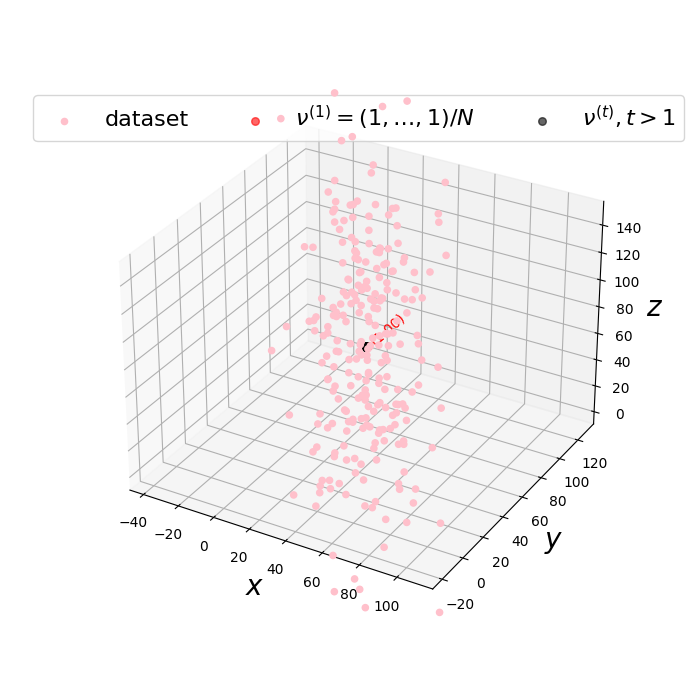

In [154]:
%matplotlib ipympl

zoom = 0.8

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')

ax.scatter(x[:,0],x[:,1],x[:,2],s=20,c='pink',alpha=1,label='dataset',zorder=0)

for i in range(T+1):
    if i == 0:
        ax.scatter(nu[i,0],nu[i,1],nu[i,2],s=30,c='red',alpha=0.6,label=r'$\nu^{(1)}=(1,\ldots,1)/N$',zorder=5)
    elif i == T:
        ax.scatter(nu[i,0],nu[i,1],nu[i,2],s=30,c='black',alpha=0.6,label=r'$\nu^{(t)},t>1$',zorder=5)
    else:
        ax.scatter(nu[i,0],nu[i,1],nu[i,2],s=30,c='black',alpha=0.6,zorder=10)

for i in range(num_centers):
    ax.scatter(centers[i,0],centers[i,1],centers[i,2],s=30,c='red',alpha=0.6,zorder=10)
    label = '({:.2f})'.format(weights[i])
    ax.text(centers[i,0],centers[i,1],centers[i,2],label,'y',c='red')

ax.legend(loc='upper center',fontsize=16, ncol=3)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$y$', fontsize=20)
ax.set_zlabel('$z$', fontsize=20)

for i,fn in enumerate([ax.set_xlim,ax.set_ylim,ax.set_zlim]):
    fn(nu_best[i]-zoom*(upper_bnds[i]-lower_bnds[i]),nu_best[i]+zoom*(upper_bnds[i]-lower_bnds[i]))

plt.show()